# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises

Perform statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes by answering the following questions: 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [23]:
# Importing necessary columns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style()
%matplotlib inline

Since the data is `stata` file, it is saved in `.dta` format.

In [2]:
# Reading the data
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [4]:
# Columns of the dataframe
data.columns

Index(['id', 'ad', 'education', 'ofjobs', 'yearsexp', 'honors', 'volunteer',
       'military', 'empholes', 'occupspecific', 'occupbroad', 'workinschool',
       'email', 'computerskills', 'specialskills', 'firstname', 'sex', 'race',
       'h', 'l', 'call', 'city', 'kind', 'adid', 'fracblack', 'fracwhite',
       'lmedhhinc', 'fracdropout', 'fraccolp', 'linc', 'col', 'expminreq',
       'schoolreq', 'eoe', 'parent_sales', 'parent_emp', 'branch_sales',
       'branch_emp', 'fed', 'fracblack_empzip', 'fracwhite_empzip',
       'lmedhhinc_empzip', 'fracdropout_empzip', 'fraccolp_empzip',
       'linc_empzip', 'manager', 'supervisor', 'secretary', 'offsupport',
       'salesrep', 'retailsales', 'req', 'expreq', 'comreq', 'educreq',
       'compreq', 'orgreq', 'manuf', 'transcom', 'bankreal', 'trade',
       'busservice', 'othservice', 'missind', 'ownership'],
      dtype='object')

In [4]:
# Number of callbacks for black-sounding names
sum(data[data.race=='w'].call)

235.0

In [5]:
# First 5 rows
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


## Solutions:

Since we will be working only on two columns, we drop the unnecessary columns in place.

In [6]:
# Shape of the data before dropping the columns
data.shape

(4870, 65)

In [5]:
# Concatinating `race` and `call` columns
data = pd.concat([data['race'], data['call']], axis = 1)

# Shape of updated dataframe
data.shape

(4870, 2)

### 1. What test is appropriate for this problem? Does CLT apply?

(i). Two-sample t-test is appropiate because we are trying to determine if two population means are equal. <br>
(ii). CLT applies because our sample size is large (n = 4870) and observations are independent.

### 2.  What are the null and alternate hypotheses?

Null Hypothesis: The mean difference between callback rate for black & white-sounding names is zero <br>
Alternative Hypothesis: There is a significant (non-zero) difference between callback rate for black & white-sounding names

### 3. Compute margin of error, confidence interval, and p-value.

In [12]:
# 'Black' and 'White' samples 
b = data[data['race'] == 'b']['call']
w = data[data['race'] == 'w']['call']

# Percentage of each 'sub-samples' who have received a call (call-back rate)
b_cbr = np.sum(b)/len(b)
w_cbr = np.sum(w)/len(w)

In [13]:
print('Call back rate (Black): ', b_cbr)
print('Call back rate (White): ', w_cbr)

Call back rate (Black):  0.064476386037
Call back rate (White):  0.0965092402464


We notice that the 'call-back rates' of two communities differ, in fact, the 'call-back rate' of `white` community is higher than that of the `black` community. 

To verify if this is not due to random chance, we have to analyze the same for datasets with larger sample size. Given the constraints, collecting additional data is not possible. Hence, we perform <strong> permutation sampling </strong>. 

For a given dataset with two classes, permutation is the process of 
(i) seperating the respective classes 
(ii) randomly sampling the observations (ignoring the class)
(iii) assigning the first n/2 observations to the first class and the rest, to the second class.

Any statistical measure calculated on the permuted data is called the "permutation replicate". We then proceed to calculate the sample mean distribution and confidence intervals of the permuted samples. 

** Note **: The p-value will be the percentage of the <strong> permutated </strong> class of interest that is lower than the percentage of <strong> current </strong> class of interest.

In [15]:
sum(data[data.race=='b'].call)

157.0

In [18]:
# Concatenated array
bw = np.concatenate((b, w))

# Initiate an empty array
b_perm_rep = np.empty(10000)

# Draw random permutation samples on the 'concatenated' data
for i in range(10000):
    bw_perm = np.random.permutation(bw)
    b_perm = bw_perm[:157]
    b_perm_rep[i] = np.sum(b_perm)/len(b_perm)

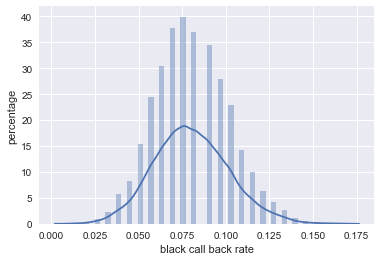

In [24]:
#to show the distribution of the resampled black call back percentage
sns.distplot(b_perm_rep)
plt.xlabel('black call back rate')
plt.ylabel('percentage')
plt.show()

In [27]:
# Confidence interval (95%)
np.percentile(black_perm_rep, [2.5, 97.5])

array([  0.00000000e+00,   3.21711265e+22])

In [28]:
p = np.sum(b_perm_rep < b_per)/len(b_perm_rep)
p

0.26840000000000003

### 4. Write a story describing the statistical significance in the context of the original problem.

`p` is higher than level of significance(0.5); Hence, this leads to failure to reject our null hypothesis.

<div class="alert alert-success">
In other words, we fail to reject "The mean difference between callback rate for `black-sounding names` & `white-sounding names` is zero".
</div>

### 5. Does the analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

Though the p-value is less than the level of significance, it does not indicate that race is the most important factor in callback success. 

To efficiently answer this question, we also have to test the `level of significance` on other features given in the dataset such as `education`, `yearsexp`, `honors`, `specialskills`.